## HFpy 코드 상세 설명

### 개요

- 지하개발을 위한 지반조사는 통상적으로 수직시추공을 통해 수행되며 초기지압 측정을 위한 수압파쇄시험 역시 수직시추공을 이용함. 이 방법은 세 방향의 주응력 중 하나의 방향을 수직으로 가정하고 시추공 종방향에 수직인 평면 상에서 다른 두 주응력을 구함.
- 근래 지하개발 목적이 다양해지면서 지하공간 형태나 현지암반의 균열대 분포에 따라 경사시추공을 이용한 삼차원 초기지압 측정이 요구되고 있음. 삼차원 응력 해석은 고려해야 할 변수가 많을 뿐만 아니라 현지 측정값과 계산값의 오차를 최소화하는 최적화 과정을 거쳐야 함(KIGAM 기본사업 단계보고서, 2021).
- 반복 계산을 수행해야 하므로 Fortran, Matlab으로 작성한 기존 코드가 있으나, 본 과제에서는 오픈소스로 손쉽게 작성 및 활용할 수 있도록 Python으로 재작성하였음.
- Python의 장점을 활용(Harris et al., 2020)하여 기존 코드보다 단순한 형태로 작성하였으며 결과 가시화도 개선하였음.
- 응력 계산에 사용된 식과 측정값 등은 Synn et al. (2015)를 참조하였음.

### 기존 데이터파일 활용

- 앞서 제작된 코드는 현장조사 정보가 있는 dat 파일을 읽어들여 계산 수행 및 그래프 생성하는 방식이었음.
- 본 코드도 기존 자료를 활용하기 위해 dat 파일을 지정하도록 구성하였음.
- dat 파일 양식은 아래와 같음.

```
0.028	98	2.404					
0.05	0.035	0.02404	0.	0.	0.	0.	0.
24
1	133.3	20.5	136.5 	4.519 	274	0	
1	133.3	20.5	139.0 	5.920 	84	1	
1	133.3	20.5	149.5 	6.946 	8	28	
1	133.3	20.5	149.5 	6.946 	251	2	
1	133.3	20.5	153.0 	5.159 	198	50	
1	348.3	10.3	121.0 	4.008 	107	7	
1	348.3	10.3	121.0 	4.008 	89	3	
1	348.3	10.3	126.5 	3.620 	68	37	
1	348.3	10.3	129.0 	4.780 	115	9	
1	348.3	10.3	129.0 	4.780 	90	3	
1	348.3	10.3	134.5 	5.064 	170	14	
1	348.3	10.3	140.0 	4.329 	171	61	
1	348.3	10.3	140.0 	4.329 	16	57	
1	348.3	10.3	140.0 	4.329 	8	74	
1	0	0	138.5 	6.527 	343	10	
1	0	0	143.5 	7.249 	171	8	
1	0	0	143.5 	7.249 	238	8	
1	133.3	20.5	141.1 	5.120 	91	11	
1	133.3	20.5	160.3 	5.455 	93	15	
1	0	0	145.5 	4.741 	83	32	
1	0	0	149.0 	5.228 	277	4
1	348.3	10.3	144.0 	6.466 	164	4	
1	348.3	10.3	148.5 	4.571 	339	39	
1	348.3	10.3	151.5 	6.095 	21	11
	
```


- 1행
    - 암반밀도(MN/m^3), 지표면으로부터 기준이 되는 지점까지의 심도(m), 기준 지점까지의 수직응력(MPa)
    - 상기 예제는 밀도 0.028 MN/m^3인 암반층이 98 m 심도에서 나타나고 암반층 상부의 수직응력이 2.404 MPa인 경우
- 2행
    - 응력해석에 사용되는 8개 변수의 기준 지점에서의 초기 설정값
- 3행
    - 입력 데이터 개수  
- 4행 이하
    - findex, $\alpha$, $\beta$, 측정심도(m), shut-in pressure 측정값(MPa), $\psi$, $\phi$
    - findex는 longitudinal fracture 0, transverse fracture 1로 구분하며 이 값에 따라 다른 계산식을 사용
    - findex가 1인 경우 shut-in pressure 측정값만 주어지며, 0인 경우 reopening pressure 측정값 필요
    - 상세한 설명은 아래와 같이 Synn et al.(2016) 참조
       
    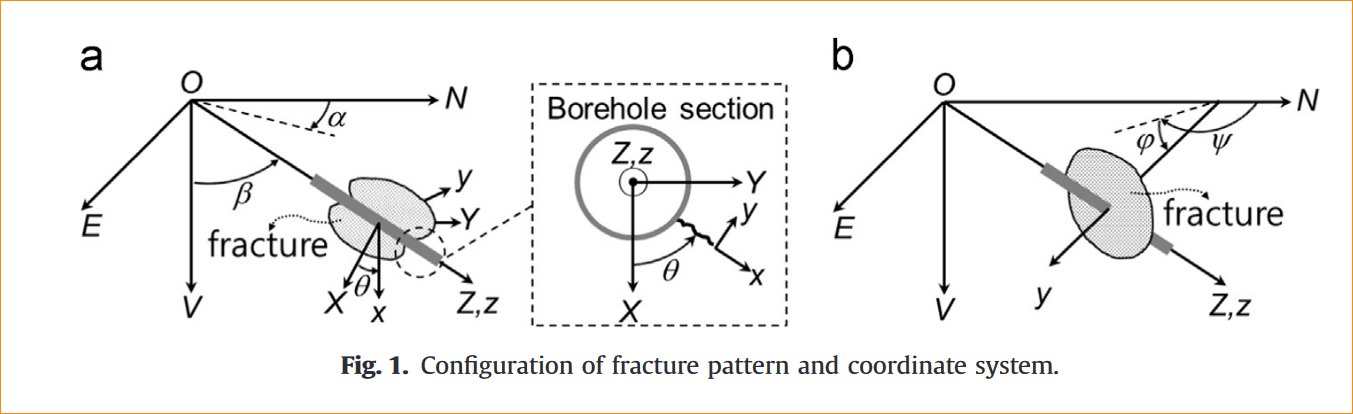      
            
> (a) A longitudinal fracture, with its plane parallel to the borehole axis
(b) A transverse fracture, with its plane inclined to the borehole axis
θ is the direction of the fracture from the X-axis
    
> We consider three coordinate systems for a longitudinal fracture as shown in Fig. 1(a). The N–E–V coordinate represents the azimuth of north, east, and vertical direction. The X–Y–Z coordinate is related to borehole geometry where X–Y is on the plane of a borehole section and Z is the direction of a borehole axis. The x–y–z coordinate is related to a fracture geometry where x–y is on the fracture plane and z is the same direction as Z. And α is the bearing of the borehole from the N-axis, β is the inclination of the borehole from the V-axis, and θ is the direction of the fracture from the X-axis.
    



### 목적함수 정의

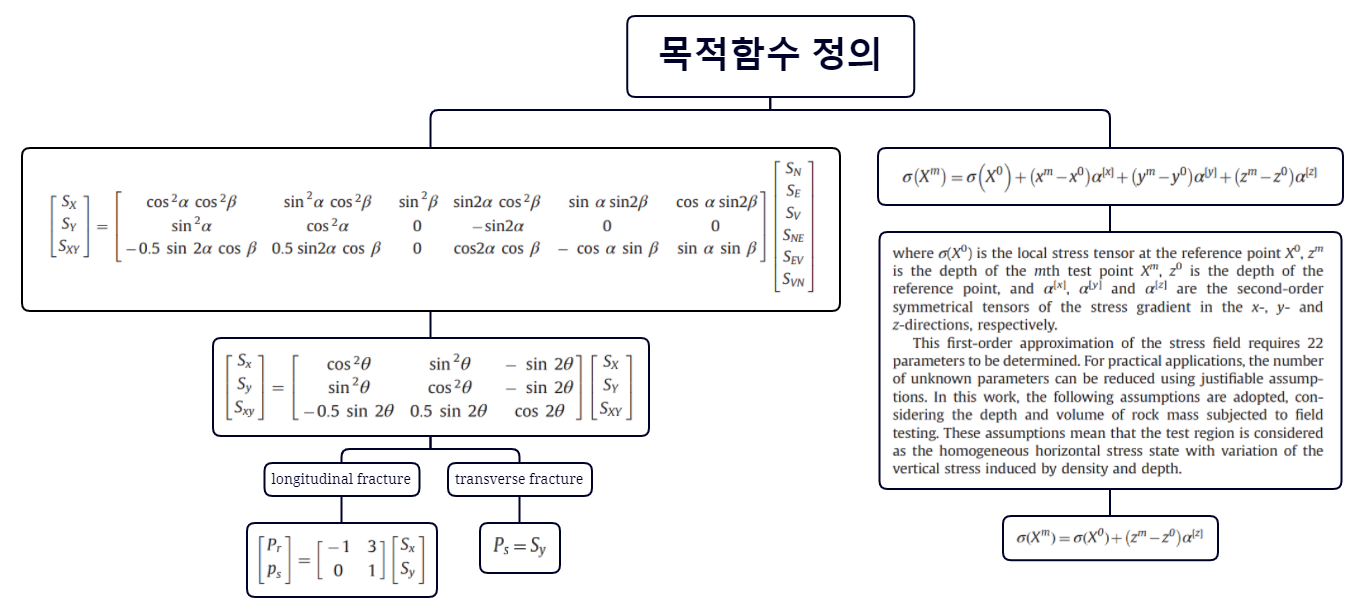


우측 프로세스에 따라 어떤 지점의 $S_N, \ S_E, \ S_V, \ S_{NE}, \ S_{EV}, \ S_{VN}$는 기준이 되는 지점의 6개 응력값과 2개의 심도에 따른 응력변화율($\alpha_{NN}, \ \alpha_{EE}$)로 구할 수 있음.

\begin{array}{cc}
S_N &= &S_{N0} \ &+ \ &\alpha_{NN}\ (z-z_0)\\
S_E &= &S_{E0} \ &+ \ &\alpha_{EE}\ (z-z_0)\\
S_V &= &S_{V0} \ &+ \ &\alpha_{VV}\ (z-z_0)\\
S_{NE} &= &S_{NE0} \ &+ \ &\alpha_{NE}\ (z-z_0)\\
S_{EV} &= &S_{EV0} \ &+ \ &\alpha_{EV}\ (z-z_0)\\
S_{VN} &= &S_{VN0} \ &+ \ &\alpha_{VN}\ (z-z_0)\\
\end{array}

\begin{array}{cc}
\alpha_{VV} &= \rm{density} \\
\alpha_{NE} &= \frac{1}{2} (\alpha_{NN} - \alpha_{EE}) \times \frac{2 S_{NE0}}{{S_{N0}} \ - \ {S_{E0}}} \\
\alpha_{EV} &= \frac{1}{2} (\alpha_{EE} - \alpha_{VV}) \times \frac{2 S_{EV0}}{{S_{E0}} \ - \ {S_{V0}}} \\
\alpha_{VN} &= \frac{1}{2} (\alpha_{VV} - \alpha_{NN}) \times \frac{2 S_{VN0}}{{S_{V0}} \ - \ {S_{N0}}} \\
\end{array}

한편, 좌측 식에 따라 $S_N, \ S_E, \ S_V, \ S_{NE}, \ S_{EV}, \ S_{VN}$로부터 어떤 심도의 이론적 reopening pressure 및 shut-in pressure를 계산할 수 있음.

이렇게 여러 지점에서 계산으로 구한 값과 측정값 간 오차의 합 또는 오차의 제곱의 합을 최소가 되게 하는 **기준 심도에서의 응력값 6개와 응력변화율 2개 값**을 찾으면 됨.

### 코드 상세

- 코드는 크게 세 부분-입력 자료 읽기, 최적화를 통한 값 찾기, 그래프 및 파일 출력-으로 구성됨.
- 전체 구조는 다음과 같이 라이브러리 불러오기, 함수 정의, main()으로 구성됨.

```python
import numpy as np
import ...

def calMF(args):
        ...
        
def __name__ == "__main__":
    ...
```

#### 라이브러리 가져오기 및 함수 정의

In [ ]:
import math

from tkinter import Tk
from tkinter.filedialog import askopenfilename

import numpy as np
import pandas as pd

import plotly.express as px
import plotly.io as pio

import matplotlib as mpl
import matplotlib.patheffects as effects
import matplotlib.pyplot as plt
import mplstereonet

from scipy.optimize import least_squares, minimize

def fs(nn: int, deg: list):
    nnn = np.repeat(nn, len(deg))
    return np.array(list(map(lambda ldeg, lnn: math.sin(math.radians(ldeg))**lnn, deg, nnn)))


def fc(nn: int, deg: list):
    nnn = np.repeat(nn, len(deg))
    return np.array(list(map(lambda ldeg, lnn: math.cos(math.radians(ldeg))**lnn, deg, nnn)))


def calMF(x0: list, data: list):

    global psc_final, fSN, fSE, fSV, fSNE, fSEV, fSVN

    psc = np.zeros(len(data[0]))

    [SN0, SE0, SV0, SNE0, SEV0, SVN0, alphaNN, alphaEE] = \
        [np.repeat(item, len(data[0])) for item in x0]
    den, tdepth, over = data[0:3]
    fractype, alpha, beta, dep, psm, psi, pi = data[3:10]

    depth = dep - tdepth

    alphaVV = den
    alphaNE = 0.5*(alphaNN-alphaEE)*2.*SNE0/(SN0-SE0)
    alphaEV = 0.5*(alphaEE-alphaVV)*2.*SEV0/(SE0-SV0)
    alphaVN = 0.5*(alphaVV-alphaNN)*2.*SVN0/(SV0-SN0)

    SN = SN0 + depth*alphaNN
    SE = SE0 + depth*alphaEE
    SV = SV0 + depth*alphaVV
    SNE = SNE0 + depth*alphaNE
    SEV = SEV0 + depth*alphaEV
    SVN = SVN0 + depth*alphaVN

    ver = tuple([fractype == 0])
    inc = tuple([fractype > 0])

    psc[inc] = SN[inc]*fc(2., pi)[inc]*fc(2., psi)[inc] + SE[inc]*fc(2., pi)[inc]*fs(2., psi)[inc] + SV[inc]*fs(2., pi)[inc] + SNE[inc]*fc(2., pi)[inc]*fs(1., 2.*psi)[inc] + SEV[inc]*fs(1., 2.*pi)[inc]*fs(1., psi)[inc] + SVN[inc]*fs(1., 2.*pi)[inc]*fc(1.,psi)[inc]

    psc_final = psc
    
    fSN, fSE, fSV, fSNE, fSEV, fSVN = [SN, SE, SV, SNE, SEV, SVN]

    errsum = (psm-psc)**2.
    errsum = (errsum.sum()/(len(errsum)-1))**.5

    return errsum

- 상기 코드에서 $\rm{fs}(n,\theta)=\sin^n \theta$ 로 작업 편의를 위해 작성하였음. 여기서 $\theta$는 벡터 연산을 고려하여 리스트 형태로 주어짐.
- 아래 코드는 함수의 계산값을 확인하기 위한 것으로 전체 코드와는 관련 없음.

In [ ]:
deg = [0, 15, 30, 45, 60, 75]
test1 = fs(1,deg)
test2 = fs(2,deg)
print(test1)
print(test2)


- calMF(x0, args) 함수는 각 측정위치별 측정값과 계산값 차이의 제곱합을 다음과 같이 구해서 반환함.
$$ {calMF} = \left( \frac{ \sum{(P_{sm} - P_{sc})^2}}{n-1} \right) ^{\frac{1}{2}} $$

- 주어진 dat 자료를 이용하여 설명하면, x0는 8개 독립변수(응력값 6개, 응력변형률값 2개), args(아래 코드에서의 data)는 24개 측정심도마다 10개씩 총 240개 인자로서 이 값을 받아 한 번에 24개 지점의 shut-in pressure 측정값과 계산값을 구하여 주어진 식에 따라 오차합을 구해 반환해 줌.

#### main()- (1) dat 파일 읽기 및 최적화 입력 자료 생성

In [ ]:
if __name__ == "__main__":

    # reading dat file
    filename = "HF.DAT"   
    data_file = open(filename, mode='r')

    # line 1-3
    density, tdepth, tburden = [
        float(xx) for xx in data_file.readline().replace("\n", "").split('\t')[0:3]]
    x0 = [float(xx)
          for xx in data_file.readline().replace("\n", "").split('\t')]
    norows = int(data_file.readline().replace("\n", "").split('\t')[0])
    
    # line 4-
    temp = list()
    for ii in range(0, norows, 1):
        temp.append(data_file.readline().replace("\n", "").split('\t'))

    m = pd.DataFrame(temp, columns=[
        'findex', 'bbering', 'binclin', 'mdepth', 'psm', 'fstrike', 'fdip', 'dummy'])

    
    cden = np.repeat(density, norows)
    cz0 = np.repeat(tdepth, norows)
    cburden = np.repeat(tburden, norows)

    fi = np.array(m.findex, dtype=int)
    bb = np.array(m.bbering, dtype=float)
    incl = np.array(m.binclin, dtype=float)
    mdep = np.array(m.mdepth, dtype=float)
    psm = np.array(m.psm, dtype=float)
    fstr = np.array(m.fstrike, dtype=float)
    fdip = np.array(m.fdip, dtype=float)

    data = [cden, cz0, cburden, fi, bb, incl, mdep, psm, fstr, fdip]

- 최적화를 위한 입력자료로는 기준 심도에서의 응력값 6개와 응력변화율 2개 값에 대한 초기 추정값 리스트 x0(dat 2행 데이터)와 벡터연산이 가능하도록 dat 1행 데이터와 4행 이하 데이터로 구성한 리스트 data임. 
- Python에서 리스트는 순서가 있는 수정가능한 객체의 집합(https://wikidocs.net/16036) 으로 대괄호로 묶고 내부 원소는 콤마로 구분함.

#### main()-(2) 최적화 프로세스
- 라이브러리 import 부분에서 선언된 대로 scipy.optimize.minimize를 사용하여 최적화함.
- 다음과 같이 함수를 사용하면 calMF(x0, data)가 반환하는 값이 최소가 되도록 x0의 값을 Broyden–Fletcher–Goldfarb–Shanno (BFGS) 알고리즘에 따라 변화시키면서 기준치(tol) 미만이 될 때까지 반복계산함.
- 반환값이 기준을 만족하는 최소값이 되면 반복계산이 종료되고 최적 조건에서의 변수 8개 값 result.x를 알 수 있음.


In [ ]:
    result = minimize(calMF, x0, data, tol=1.e-6, method='BFGS')

In [ ]:
print(result.x)

- scipy는 십여 개가 넘는 method를 제공하고 있으며, method에 따라 제한된 범위에서 답을 구하거나 국부적 수렴을 피하기 위해 전체 영역을 모두 계산하는 것이 가능해짐.
- 다음 코드로 SLSQP(Sequential Least Squares Programming)를 적용했을 때 구한 결과와 두 결과 간 값 차이를 확인할 수 있음.

In [ ]:
    compare = minimize(calMF, x0, data, tol=1.e-6, method='SLSQP')
    print(compare.x)
    print(abs(result.x-compare.x))

In [ ]:
    df = pd.DataFrame([fi, mdep, cz0, mdep-cz0, psc_final, psm,
                      psm-psc_final, fSV-(cburden+cden*(mdep-cz0)), fSN, fSE, fSV, fSNE, fSEV, fSVN])
    df = df.T
    df.columns = ["Fracture_type", "mdepth", "tdepth", "depth", "Psc", "Psm",
                  "tolPs", "tolPv", "PN", "PE", "PV", "PNE", "PEV", "PVN"]

- 8개 변수와 측정심도를 이용하여 계산한 최종 결과를 상기 코드를 이용하여 pandas의 데이터프레임 df로 저장하였음. 
- Python은 오픈소스의 단점을 극복하기 위해 문서화를 중시하며, 라이브러리마다 매우 충실한 자료를 제공하므로 pandas, numpy, scipy, plotly 등의 공식 홈페이지에서 검색으로 상세한 정보를 얻을 수 있음.
- head, tail 등을 이용하여 데이터프레임 상위, 하위 5개(옵션)의 값을 확인하면 다음과 같음.

In [ ]:
df.head()

In [ ]:
df.tail()

#### main()-(3-1) 그래프 생성 

- python에서 그래프 생성 시 많이 사용하는 plotly 라이브러리를 이용하였음. 
- gf1, gf2 등 일련의 데이터 series를 만든 후 gf로 결합하고 scatter 형식으로 도시함.
- 코드가 직관적이라 관련 사항들을 바로 파악할 수 있음.


In [ ]:
    gf1 = pd.concat([df.tolPs, df.mdepth], axis=1)
    gf1.rename(columns={"tolPs": "X"}, inplace=True)
    gf1["Legend"] = "Psm-Psc"

    gf2 = pd.concat([df.tolPv, df.mdepth], axis=1)
    gf2.rename(columns={"tolPv": "X"}, inplace=True)
    gf2["Legend"] = "PN-(tburden+depth*den)"

    gf = pd.concat([gf1, gf2])

    fig1 = px.scatter(
        gf,
        x="X",
        y="mdepth",
        color="Legend",
        labels=dict(
            X="Psm-Psc or PN-(tburden+depth*den) (MPa)",
            mdepth="Depth (m)",
            Legend="Stress (MPa)",
        ),
        width=800,
        height=700,
    )

    fig1.update_traces(
        marker=dict(size=12, line=dict(width=2, color="DarkSlateGrey")),
        selector=dict(mode="markers"),
    )

    fig1.update_yaxes(
        autorange="reversed",
        showgrid=True,
        gridwidth=1,
        gridcolor="LightGrey",
        mirror=True,
    )
    
    x_axis_max = max(max(abs(df.tolPs)), max(abs(df.tolPv)))
    
    fig1.update_xaxes(
        range=[-x_axis_max * 1.2, x_axis_max * 1.2],
        showgrid=True,
        gridwidth=1,
        gridcolor="LightGrey",
        mirror=True,
    )
    
    fig1.update_layout(
        template="simple_white",
        legend=dict(font=dict(size=14)),
        margin=dict(l=100, r=150, t=50, b=50),
    )

    fig1.show()

In [ ]:
    gf1 = pd.concat([df.PN, df.mdepth], axis=1)
    gf1.rename(columns={"PN": "X"}, inplace=True)
    gf1["Legend"] = "PN"

    gf2 = pd.concat([df.PE, df.mdepth], axis=1)
    gf2.rename(columns={"PE": "X"}, inplace=True)
    gf2["Legend"] = "PE"

    gf3 = pd.concat([df.PV, df.mdepth], axis=1)
    gf3.rename(columns={"PV": "X"}, inplace=True)
    gf3["Legend"] = "PV"

    gfA = pd.concat([gf1, gf2, gf3])

    fig2 = px.scatter(
        gfA,
        x="X",
        y="mdepth",
        color="Legend",
        trendline="ols",
        labels=dict(X="PN or PE or PV (MPa)", mdepth="Depth (m)", Legend="Stress"),
        width=800,
        height=700,
    )

    PNEV_results = px.get_trendline_results(fig2).px_fit_results.iloc[0:3]

    fig2.update_traces(
        marker=dict(size=12, line=dict(width=2, color="DarkSlateGrey")),
        selector=dict(mode="markers"),
    )

    fig2.update_yaxes(
        autorange="reversed",
        showgrid=True,
        gridwidth=1,
        gridcolor="LightGrey",
        mirror=True,
    )
    x_axis_max = max(
        max(df.PN), max(df.PE), max(df.PV), max(df.PNE), max(df.PEV), max(df.PVN)
    )
    x_axis_min = min(
        0,
        min(min(df.PN), min(df.PE), min(df.PV)),
        min(min(df.PNE), min(df.PEV), min(df.PVN)),
    )
    fig2.update_xaxes(
        range=[x_axis_min * 1.2, x_axis_max * 1.2],
        showgrid=True,
        gridwidth=1,
        gridcolor="LightGrey",
        mirror=True,
    )

    fig2.update_layout(
        template="simple_white",
        legend=dict(font=dict(size=12)),
        margin=dict(l=100, r=150, t=50, b=50),
    )
    anno = f"<b>Y=a+bX</b><br><b>PN</b><br>a: {PNEV_results[0].params[0]:0.3f}<br>b: {PNEV_results[0].params[1]:0.3f}<br>r2: {PNEV_results[0].rsquared:0.3f}<br><b>PE</b><br>a: {PNEV_results[1].params[0]:0.3f}<br>b: {PNEV_results[1].params[1]:0.3f}<br>r2: {PNEV_results[1].rsquared:0.3f}<br><b>PV</b><br>a: {PNEV_results[2].params[0]:0.3f}<br>b: {PNEV_results[2].params[1]:0.3f}<br>r2: {PNEV_results[0].rsquared:0.3f}<br>"
    fig2.add_annotation(
        text=anno,
        font=dict(size=14),
        align="left",
        showarrow=False,
        xref="paper",
        yref="paper",
        x=1.01,
        y=0.65,
        xanchor="left",
        yanchor="top",
        bordercolor="black",
        borderwidth=0,
    )
    
    fig2.show()

In [ ]:
    gf4 = pd.concat([df.PNE, df.mdepth], axis=1)
    gf4.rename(columns={"PNE": "X"}, inplace=True)
    gf4["Legend"] = "PNE"

    gf5 = pd.concat([df.PEV, df.mdepth], axis=1)
    gf5.rename(columns={"PEV": "X"}, inplace=True)
    gf5["Legend"] = "PEV"

    gf6 = pd.concat([df.PVN, df.mdepth], axis=1)
    gf6.rename(columns={"PVN": "X"}, inplace=True)
    gf6["Legend"] = "PVN"

    gfB = pd.concat([gf4, gf5, gf6])

    fig4 = px.scatter(
        gfB,
        x="X",
        y="mdepth",
        color="Legend",
        trendline="ols",
        labels=dict(X="PNE or PEV or PVN (MPa)", mdepth="Depth (m)", Legend="Stress"),
        width=800,
        height=700,
    )

    PNEV_results = px.get_trendline_results(fig4).px_fit_results.iloc[0:3]

    fig4.update_traces(
        marker=dict(size=12, line=dict(width=2, color="DarkSlateGrey")),
        selector=dict(mode="markers"),
    )

    fig4.update_yaxes(
        autorange="reversed",
        showgrid=True,
        gridwidth=1,
        gridcolor="LightGrey",
        mirror=True,
    )
    fig4.update_xaxes(
        range=[x_axis_min * 1.2, x_axis_max * 1.2],
        showgrid=True,
        gridwidth=1,
        gridcolor="LightGrey",
        mirror=True,
    )

    fig4.update_layout(
        template="simple_white",
        legend=dict(font=dict(size=12)),
        margin=dict(l=100, r=150, t=50, b=50),
    )
    anno = f"<b>Y=a+bX</b><br><b>PNE</b><br>a: {PNEV_results[0].params[0]:0.3f}<br>b: {PNEV_results[0].params[1]:0.3f}<br>r2: {PNEV_results[0].rsquared:0.3f}<br><b>PEV</b><br>a: {PNEV_results[1].params[0]:0.3f}<br>b: {PNEV_results[1].params[1]:0.3f}<br>r2: {PNEV_results[1].rsquared:0.3f}<br><b>PVN</b><br>a: {PNEV_results[2].params[0]:0.3f}<br>b: {PNEV_results[2].params[1]:0.3f}<br>r2: {PNEV_results[2].rsquared:0.3f}<br>"
    fig4.add_annotation(
        text=anno,
        font=dict(size=14),
        align="left",
        showarrow=False,
        xref="paper",
        yref="paper",
        x=1.01,
        y=0.65,
        xanchor="left",
        yanchor="top",
        bordercolor="black",
        borderwidth=0
    )
    
    fig4.show()

In [ ]:
    gfAll = pd.concat([gfA, gfB])

    fig5 = px.scatter(
        gfAll,
        x="X",
        y="mdepth",
        color="Legend",
        trendline="ols",
        labels=dict(X="Stress (MPa)", mdepth="Depth (m)", Legend="Stress"),
        width=800,
        height=700,
    )

    fig5.update_traces(
        marker=dict(size=12, line=dict(width=2, color="DarkSlateGrey")),
        selector=dict(mode="markers"),
    )

    fig5.update_yaxes(
        autorange="reversed",
        showgrid=True,
        gridwidth=1,
        gridcolor="LightGrey",
        mirror=True,
    )
    fig5.update_xaxes(
        range=[x_axis_min * 1.2, x_axis_max * 1.2],
        showgrid=True,
        gridwidth=1,
        gridcolor="LightGrey",
        mirror=True,
    )

    fig5.update_layout(
        template="simple_white",
        legend=dict(font=dict(size=12)),
        margin=dict(l=100, r=150, t=50, b=50),
    )
    
    fig5.show()

#### main()-(3-2) 주응력 계산
- 6개의 응력성분으로 구성된 Cauchy stress tensor는 다음 식과 같이 대각성분이 모두 0인 평면이 적어도 하나는 존재함.

$ \begin{bmatrix}
    \sigma_{11} & \sigma_{12} & \sigma_{13} \\
    \sigma_{21} & \sigma_{22} & \sigma_{23} \\
    \sigma_{31} & \sigma_{32} & \sigma_{33} 
   \end{bmatrix} 
  \begin{bmatrix}
    n_1 \\
    n_2 \\
    n_3  
   \end{bmatrix} = \lambda 
  \begin{bmatrix}
    n_1 \\
    n_2 \\
    n_3  
   \end{bmatrix} $
  
  - 이 응력상태의 방향을 주응력방향이라고 하며 이 방향에 수직인 평면은 주응력평면이 됨. 
  - 즉 단순히 응력텐서의 고유값을 구하게 되면 고유값(eigenvalue)은 주응력 크기를 나타내며 고유벡터(eigenvector)는 주응력방향을 알려줌.
  

In [ ]:
    # ---- Stereonet -------
    mag = [[] for i in range(3)]
    vec = [[] for i in range(3)]

    for idx, [PN, PE, PV, PNE, PEV, PVN] in df[["PN", "PE", "PV", "PNE", "PEV", "PVN"]].iterrows():
        sigma = np.asarray([[PN, PNE, PVN],
                            [PNE, PE, PEV],
                            [PVN, PEV, PV]])
        
        e_val, e_vec = np.linalg.eig(sigma)

        # sort by magnitude of eigenvalues
        idx = e_val.argsort()[::-1]
        e_val = e_val[idx]
        e_vec = e_vec[:, idx]

        for ii in range(0, 3):
            mag[ii].append(e_val[ii])
            vec[ii].append(e_vec[ii])

    df["P1mag"] = mag[0]
    df["P2mag"] = mag[1]
    df["P3mag"] = mag[2]
    df["P1vec"] = vec[0]
    df["P2vec"] = vec[1]
    df["P3vec"] = vec[2]

    x1 = [xx[0] for xx in df["P1vec"]]
    y1 = [xx[1] for xx in df["P1vec"]]
    z1 = [xx[2] for xx in df["P1vec"]]
    x2 = [xx[0] for xx in df["P2vec"]]
    y2 = [xx[1] for xx in df["P2vec"]]
    z2 = [xx[2] for xx in df["P2vec"]]
    x3 = [xx[0] for xx in df["P3vec"]]
    y3 = [xx[1] for xx in df["P3vec"]]
    z3 = [xx[2] for xx in df["P3vec"]]

- 상기 코드에 대한 상세 설명은 다음과 같음.
    - for ~ in df.iterrows()를 이용하여 측정지점을 한 줄씩 순회함.
    - numpy.linalg.eig() 함수를 이용하여 응력텐서 sigma의 eigenvalues, eigenvectors를 구함.
    - eigenvalue 크기에 따라 e_val, e_vec 순서를 정렬함.
    - 편의를 위해 최대, 중간, 최소주응력 크기, 주응력방향 벡터요소별로 데이터를 저장해 놓음.
    - 마지막 측정지점의 정보를 출력해 보면 다음과 같음.
    - **함수를 이용하여 구한 벡터방향이 본 코드가 가정하고 있는 좌표체계에 부합하는지 확인 필요함.**

In [ ]:
print(sigma)
print(e_val)
print(e_vec)

In [ ]:
    # Set up the figure
    fig6 = plt.figure(figsize=(18, 7))
    
    ax1 = fig6.add_subplot(131, projection="stereonet")
    ax2 = fig6.add_subplot(132, projection="stereonet")
    ax3 = fig6.add_subplot(133, projection="stereonet")

    ax1.set_azimuth_ticks([])
    ax2.set_azimuth_ticks([])
    ax3.set_azimuth_ticks([])

    # Convert these to plunge/bearings for plotting.
    # Alternately, we could use xyz2stereonet (it doesn't correct for bi-directional
    # measurements, however) or vector2pole.
    plunge1, bearing1 = mplstereonet.vector2plunge_bearing(x1, y1, z1)
    plunge2, bearing2 = mplstereonet.vector2plunge_bearing(x2, y2, z2)
    plunge3, bearing3 = mplstereonet.vector2plunge_bearing(x3, y3, z3)
    strike1, dip1 = mplstereonet.vector2pole(x1, y1, z1)

    # Make a density contour plot of the orientations
    ax1.density_contourf(plunge1, bearing1, measurement="lines")
    ax1.line(plunge1, bearing1, marker="o", color="black")
    ax1.grid(True)
    ax1.set_title("Major Principal Stress")
    #ax1.set_azimuth_ticks(range(0, 360, 10))

    ax2.density_contourf(plunge2, bearing2, measurement="lines")
    ax2.line(plunge2, bearing2, marker="o", color="black")
    ax2.grid(True)
    ax2.set_title("Intermediate Principal Stress")
    #ax2.set_azimuth_ticks(range(0, 360, 10))

    ax3.density_contourf(plunge3, bearing3, measurement="lines")
    ax3.line(plunge3, bearing3, marker="o", color="black")
    ax3.grid(True)
    ax3.set_title("Minor Principal Stress")
    #ax3.set_azimuth_ticks(range(0, 360, 10))

       

In [ ]:
    # ---------
    gf1 = pd.concat([df.P1mag, df.mdepth], axis=1)
    gf1.rename(columns={"P1mag": "X"}, inplace=True)
    gf1["Legend"] = "P1"

    gf2 = pd.concat([df.P2mag, df.mdepth], axis=1)
    gf2.rename(columns={"P2mag": "X"}, inplace=True)
    gf2["Legend"] = "P2"

    gf3 = pd.concat([df.P3mag, df.mdepth], axis=1)
    gf3.rename(columns={"P3mag": "X"}, inplace=True)
    gf3["Legend"] = "P3"

    gfA = pd.concat([gf1, gf2, gf3])

    fig7 = px.scatter(
        gfA,
        x="X",
        y="mdepth",
        color="Legend",
        trendline="ols",
        labels=dict(
            X="Principal stress (MPa)", mdepth="Depth (m)", Legend="Principal<br>stress"
        ),
        width=800,
        height=700,
    )

    PRINCIPAL_results = px.get_trendline_results(fig7).px_fit_results.iloc[0:3]

    fig7.update_traces(
        marker=dict(size=12, line=dict(width=2, color="DarkSlateGrey")),
        selector=dict(mode="markers"),
    )

    fig7.update_yaxes(
        autorange="reversed",
        showgrid=True,
        gridwidth=1,
        gridcolor="LightGrey",
        mirror=True,
    )
    
    fig7.update_xaxes(
        range=[x_axis_min * 1.2, x_axis_max * 1.2],
        showgrid=True,
        gridwidth=1,
        gridcolor="LightGrey",
        mirror=True,
    )

    fig7.update_layout(
        template="simple_white",
        legend=dict(font=dict(size=12)),
        margin=dict(l=100, r=150, t=50, b=50),
    )
    
    anno = f"<b>Y=a+bX</b><br><b>P1</b><br>a: {PRINCIPAL_results[0].params[0]:0.3f}<br>b: {PRINCIPAL_results[0].params[1]:0.3f}<br>r2: {PRINCIPAL_results[0].rsquared:0.3f}<br><b>P2</b><br>a: {PRINCIPAL_results[1].params[0]:0.3f}<br>b: {PRINCIPAL_results[1].params[1]:0.3f}<br>r2: {PRINCIPAL_results[1].rsquared:0.3f}<br><b>P3</b><br>a: {PRINCIPAL_results[2].params[0]:0.3f}<br>b: {PRINCIPAL_results[2].params[1]:0.3f}<br>r2: {PRINCIPAL_results[2].rsquared:0.3f}<br>"
    
    fig7.add_annotation(
        text=anno,
        font=dict(size=14),
        align="left",
        showarrow=False,
        xref="paper",
        yref="paper",
        x=1.01,
        y=0.65,
        xanchor="left",
        yanchor="top",
        bordercolor="black",
        borderwidth=0,
    )

In [ ]:
    # ---------
    df["P12"] = df.P1mag / df.P2mag
    df["P13"] = df.P1mag / df.P3mag
    df["P23"] = df.P2mag / df.P3mag
    gf1 = pd.concat([df.P12, df.mdepth], axis=1)
    gf1.rename(columns={"P12": "X"}, inplace=True)
    gf1["Legend"] = "P1/P2"

    gf2 = pd.concat([df.P23, df.mdepth], axis=1)
    gf2.rename(columns={"P23": "X"}, inplace=True)
    gf2["Legend"] = "P2/P3"

    gf3 = pd.concat([df.P13, df.mdepth], axis=1)
    gf3.rename(columns={"P13": "X"}, inplace=True)
    gf3["Legend"] = "P1/P3"

    gfA = pd.concat([gf1, gf2, gf3])

    fig8 = px.scatter(
        gfA,
        x="X",
        y="mdepth",
        color="Legend",
        trendline="ols",
        labels=dict(X="Principal stress ratio", mdepth="Depth (m)", Legend="Legend"),
        width=800,
        height=700,
    )

    PRINCIPAL_results = px.get_trendline_results(fig8).px_fit_results.iloc[0:3]

    fig8.update_traces(
        marker=dict(size=12, line=dict(width=2, color="DarkSlateGrey")),
        selector=dict(mode="markers"),
    )

    fig8.update_yaxes(
        autorange="reversed",
        showgrid=True,
        gridwidth=1,
        gridcolor="LightGrey",
        mirror=True,
    )
    
    fig8.update_xaxes(showgrid=True, gridwidth=1, gridcolor="LightGrey", mirror=True)

    fig8.update_layout(
        template="simple_white",
        legend=dict(font=dict(size=12)),
        margin=dict(l=100, r=150, t=50, b=50),
    )
    
    anno = f"<b>Y=a+bX</b><br><b>P1/P2</b><br>a: {PRINCIPAL_results[0].params[0]:0.3f}<br>b: {PRINCIPAL_results[0].params[1]:0.3f}<br>r2: {PRINCIPAL_results[0].rsquared:0.3f}<br><b>P2/P3</b><br>a: {PRINCIPAL_results[1].params[0]:0.3f}<br>b: {PRINCIPAL_results[1].params[1]:0.3f}<br>r2: {PRINCIPAL_results[1].rsquared:0.3f}<br><b>P1/P3</b><br>a: {PRINCIPAL_results[2].params[0]:0.3f}<br>b: {PRINCIPAL_results[2].params[1]:0.3f}<br>r2: {PRINCIPAL_results[2].rsquared:0.3f}<br>"
    
    fig8.add_annotation(
        text=anno,
        font=dict(size=14),
        align="left",
        showarrow=False,
        xref="paper",
        yref="paper",
        x=1.01,
        y=0.65,
        xanchor="left",
        yanchor="top",
        bordercolor="black",
        borderwidth=0,
    )

In [ ]:
    # --- figure export ------
    fig1.write_html("0_Ps_cal_mea.html")
    fig5.write_html("1_PNEV_NEEVVN.html")
    fig2.write_html("2_PNEV.html")
    fig4.write_html("3_PNEEVVN.html")
    fig7.write_html("4_Principal.html")
    fig8.write_html("5_Principal_ratio.html")
    
    #pio.write_image(fig1, "0_Ps_cal_mea.jpg", format="jpg")
    #pio.write_image(fig5, f"{pjcode}_{hole_no}_1_PNEV_NEEVVN.jpg", format="jpg")
    #pio.write_image(fig2, f"{pjcode}_{hole_no}_2_PNEV.jpg", format="jpg")
    #pio.write_image(fig4, f"{pjcode}_{hole_no}_3_PNEEVVN.jpg", format="jpg")
    #pio.write_image(fig7, f"{pjcode}_{hole_no}_4_Principal.jpg", format="jpg")
    #pio.write_image(fig8, f"{pjcode}_{hole_no}_5_Principal_Ratio.jpg", format="jpg")

    fig6.savefig("6_Principal_stereonet.jpg")

    df.to_csv("Results.csv", index=False)

    print("Figure and csv files were exported.")